# Test German NLP Pipeline

Test NLP pipeline for dependency parsing and semantic role labeling in German.

In [222]:
import spacy
import re
import numpy as np
import seaborn as sns
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup

## Retrieve Stories From the Web

Build web scraper for German stories about the pandemic. The stories are published on a webpage from the HSPV NRW (University of Applied Sciences for the police and public administration) and written by students as well as staff. For a general description, see: https://www.hspv.nrw.de/services/corona-krise/corona-geschichten

In [2]:
# Define URL and story page ids

URL = "https://www.hspv.nrw.de/nachrichten/artikel/corona-geschichten"

ID_STORIES = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13"]

In [3]:
# Function to retrieve text from webpages

def get_text_from_web(url, ids):
    docs = []

    for id in ids:
        new_page = urlopen(url + "-" + id).read()

        new_soup = BeautifulSoup(new_page, 'html.parser')

        for script in new_soup(["script", "style"]):
            script.decompose()
        
        docs.append(list(new_soup.stripped_strings))
    
    return docs

  

Extract the relevant stories by removing text that is present in all documents (e.g., menu headers).

In [4]:
# Function to extract only text from stories

def extract_story_text(docs):
    new_docs = [[s for s in docs[0] if s not in docs[-1]]]

    for doc in docs[1:]:
        new_docs.append([s for s in doc if s not in docs[0]])
    
    return new_docs

Format the stories into a dictionary with keys:
- title: Title
- author: Author
- date: Date
- text: Text as single string

Also removes dash unicode and hashtags in the text.

In [5]:
# Function to format stories into dicts

def convert_stories_to_dict(docs):
    docs_dict = []
    
    for doc in docs:
        new_dict = {}
        title = doc[1]
        author = doc[3]
        date = doc[2]
        text = "".join(s + " " for s in doc[1:] if s not in [title, author, date]).replace("\xa0", "")
        docs_dict.append({
            "title": title,
            "author": author,
            "date": date,
            "text": text
        })
        
    return docs_dict

In [6]:
docs = get_text_from_web(URL, ID_STORIES)

In [7]:
short_docs = extract_story_text(docs)

dict_docs = convert_stories_to_dict(short_docs)

In [8]:
print(dict_docs[1]["text"])

Studienalltag in Zeiten von Corona Ann-Katrin Vengels, Studentin der HSPV NRW am Studienort Mülheim an der Ruhr, berichtet aus ihrem Alltag zwischen Homeschooling, Kinderbetreuung und Online-Studium. In den vergangenen Jahren habe ich die Frage nach meinem Befinden stets mit den Worten „Der normale Wahnsinn halt“ beantwortet. Und ja, irgendwie ist der Wahnsinn tatsächlich normal geworden. Ich bin Mutter von zwei Kindern, meine Tochter ist 13 und mein Sohn sechs. Seit zehn Jahren bin ich verheiratet. 2019 habe ich mich dazu entschlossen, meinen Beruf aufzugeben und mich weiterzuentwickeln, weshalb ich mich für ein duales Bachelorstudium an der HSPV entschieden habe. Mittlerweile studiere ich im zweiten Studienjahr Polizeivollzugsdienst und bin Kommissaranwärterin. Mein Ehemann (der inzwischen auch mein Kollege ist) und ich sind über die Jahre zu einem eingespielten Team geworden, das perfekt aufeinander eingestellt ist. Ein großer Pluspunkt, der definitiv eine wichtige Rolle bei meinem 

## Dependency Parsing and Named Entity Recognition

Before running the pipeline, the pipeline must be installed, e.g., via:

`python3 -m spacy download de_core_news_sm`

For details on the pipeline, see: https://spacy.io/models/de.


In [9]:
# Load german nlp pipeline trained on news documents (sm = small size)

nlp = spacy.load("de_core_news_sm")

In [10]:
def analyse_stories(docs):
    processed_docs = []
    
    for doc in docs:
        processed_docs.append(nlp(doc["text"]))
        
    return processed_docs

In [11]:
processed_docs = analyse_stories(dict_docs)

In [115]:
# From danlp_test notebook

def print_results(doc):
    analysis = []
    for token in doc:
        analysis.append({ 
            "text": token.text,
            "lemma": token.lemma_,
            "head": token.head.i,
            "dep": token.dep_,
            "pos": token.pos_,
            "morph_case": "".join(token.morph.get("Case")),
            "morph_person": "".join(token.morph.get("Person")),
            "morph_number": "".join(token.morph.get("Number")),
            "ent": token.ent_type_
        })
    return pd.DataFrame(analysis)

In [165]:
# From danlp_test notebook

def show_results(results_dict):
    results_df = pd.DataFrame([{ "key": key, "count": results_dict[key]} 
                               for key in sorted(results_dict, key=lambda k: results_dict[k], reverse=True)])
    return results_df

In [166]:
# From danlp_test notebook

def get_best_keys(results_df):
    best_count = -1
    best_keys = []
    for i, row in results_df.iterrows():
        if row["count"] > best_count:
            best_count = row["count"]
            best_keys = [row["key"]]
        elif row["count"] == best_count:
            best_keys.append(row["key"])
    case_is_upper = []
    for key in best_keys:
        case_is_upper.append(re.search(r"^[A-Z]", key) != None)
    if True in case_is_upper:
        best_keys = [ best_keys[i] for i in range(0, len(best_keys)) if case_is_upper[i] ] 
    return best_keys

In [167]:
# From danlp_test notebook

def get_actors(nlp_table_df):
    actors = {}
    for i, row in nlp_table_df.iterrows():
        if row["dep"] == "sb" and re.search("[a-zA-Z]", row["text"]):
            actor = row["text"]
        else:
            actor = ""
        if actor != "":
            if actor in actors:
                actors[actor] += 1
            else:
                actors[actor] = 1
    return actors

In [168]:
# From danlp_test notebook

def get_locations(nlp_table_df):
    locations = {}
    for i, row in nlp_table_df.iterrows():
        if row["ent"] == "LOC" and re.search("[a-zA-Z]", row["text"]):
            location = row["text"]
        else:
            location = ""
        if location != "":
            if location in locations:
                locations[location] += 1
            else:
                locations[location] = 1
    return locations

In [169]:
# From danlp_test notebook

def get_actions(nlp_table_df):
    actions = {}
    for i, row in nlp_table_df.iterrows():
        if row["pos"] == "VERB" and re.search("[a-zA-Z]", row["text"]):
            if row["lemma"] in actions:
                actions[row["lemma"]] += 1
            else:
                actions[row["lemma"]] = 1
    return actions

Calculate the type of agency in the story as the frequency of pronouns, nouns (and proper nouns) in nominative (agent) vs. dative/accusative (object) case.

In [247]:
def calc_agency(nlp_table_df):
    agency = (nlp_table_df[nlp_table_df.morph_case.ne("") 
                           & nlp_table_df.pos.isin(["PROPN", "NOUN", "PRON"]) 
                           & nlp_table_df.morph_case.ne("Gen")]
        .assign(agent_object = lambda dataframe: np.where(dataframe["morph_case"] == "Nom", "agent", "object"))
        .groupby(["pos", "morph_person", "morph_number", "agent_object"], as_index = False)
        .agg(count = ("text", "count"))
    )
    
    return agency

In [245]:
def concatenate_results(docs, fun):
    df_list = []
    for i, doc in enumerate(docs):
        df_list.append(show_results(fun(print_results(doc))).assign(id = i+1))
    
    return pd.concat(df_list)

Sum the counts for concatenated data frames.

In [240]:
def show_top_keys(count_df_list):
    top_keys = (count_df_list
          .groupby(["key"], as_index = False)
          .agg(count = ("count", sum))
          .sort_values(by = ["count"], ascending = False)
          .head(10)  
    )
    
    return top_keys

In [251]:
def concatenate_agency(docs):
    df_list = []
    for i, doc in enumerate(docs):
        df_list.append(calc_agency(print_results(doc)).assign(id = i+1))
    
    return pd.concat(df_list)

Plot the agency for pronouns in a bar chart.

In [274]:
def plot_pronoun_agency(agency_df):
    plot_df = (agency_df[agency_df.pos.eq("PRON") & agency_df.morph_number.ne("")]
        #.groupby(["morph_person", "morph_number", "agent_object"], as_index = False)
        #.agg(count = ("count", sum))
    )
    
    plot = sns.catplot(
        data = plot_df,
        x = "morph_person",
        y = "count",
        hue = "agent_object",
        col ="morph_number",
        kind = "point"
    )
    
    print(plot)

In [242]:
# Show top actors from all stories

show_top_keys(concatenate_results(processed_docs, get_actors))

,key,count
203,ich,110
225,wir,52
201,es,30
66,Ich,29
210,man,19
216,sie,18
190,das,17
192,die,16
222,was,13
4,Alltag,11


The storytellers themselves seem to be the most prevalent actors ("ich"). Quite often they also act as part of a group (i.e., "wir").

In [243]:
# Show top actions from all stories

show_top_keys(concatenate_results(processed_docs, get_actions))

,key,count
174,kommen,21
149,haben,17
135,gehen,16
53,berichten,15
132,geben,14
123,finden,14
189,machen,10
180,lassen,10
313,verändern,10
241,sehen,10


Interestingly, 'changing' ("verändern") seems to be quite a prevalent action.

In [244]:
# Show top locations from all stories

show_top_keys(concatenate_results(processed_docs, get_locations))

,key,count
26,Homeoffice,9
52,Mülheim,6
63,Ruhr,4
84,der,4
83,an,4
41,Lehrveranstaltungen,4
44,Lockdown,3
9,Borken,3
35,Kreis,3
14,Corona,3


Some of the keys are not actually locations (i.e., lockdown, Corona). Apparently, spaCy's named entity recognition is not very good for German due to limited training data (e.g., see https://github.com/explosion/spaCy/issues/2774). However, "Homeoffice", "Mülheim", and "Lehrveranstaltungen" (i.e., in class) seem like very plausible locations.

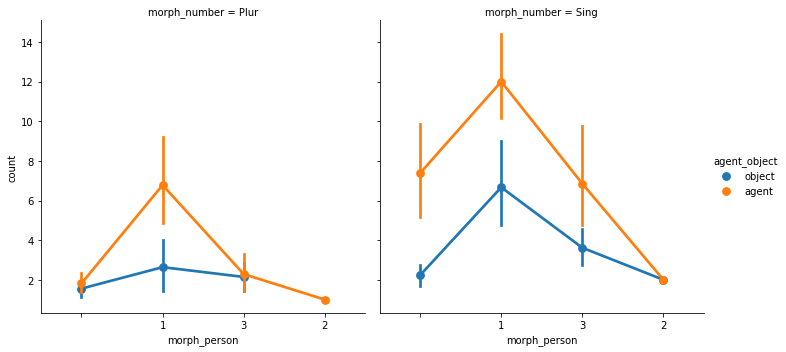

In [275]:
# Show agency across all stories

plot_pronoun_agency(concatenate_agency(processed_docs))

## Semantic Role Labeling

Only option sofar: With pre-trained tensorflow model as described in https://liir.cs.kuleuven.be/software_pages/damesrl.php. The link also contains the source code and pre-trained model files in folder `charatt_ger_march23`. The software is distributed under the Apache 2.0 license.

## Suggestions for Future Work

1. Look at tenses (past vs. future)
2. Look at sentiment